In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
(x_train, y_train), (x_test, y_test)  = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [4]:
y_train = y_train.reshape(-1,)

In [5]:
# Reshape converting 2D to 1D
y_test = y_test.reshape(-1,)
y_train = y_train.reshape(-1,)

In [6]:
# This code normalazation
x_train = x_train / 255.0
x_test = x_test / 255.0

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

# Define Alexnet Model
AlexNet = Sequential()

AlexNet.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(32,32,3), activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

AlexNet.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

AlexNet.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())

AlexNet.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())

AlexNet.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

AlexNet.add(Flatten())
AlexNet.add(Dense(512, activation='relu'))
AlexNet.add(Dropout(0.5))

AlexNet.add(Dense(256, activation='relu'))
AlexNet.add(Dropout(0.5))

AlexNet.add(Dense(10, activation='softmax'))

# Define optimizer
opt = Adam(learning_rate=0.001)

# Compile model with 'sparse_categorical_crossentropy'
AlexNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
AlexNet.summary()

# Train model
history = AlexNet.fit(datagen.flow(x_train, y_train, batch_size=64),
                      epochs=50,
                      validation_data=(x_test, y_test),
                      verbose=1)

# Access validation loss and accuracy
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                        

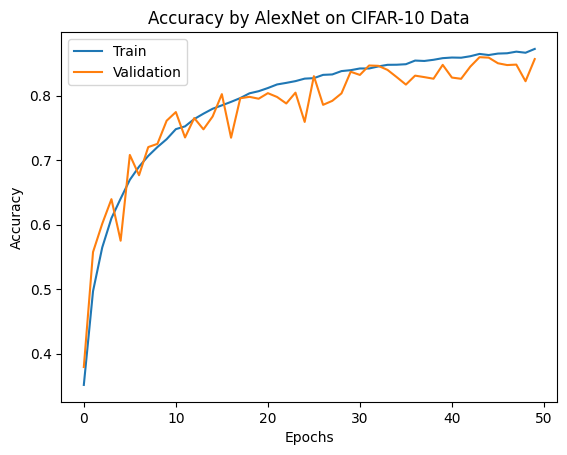

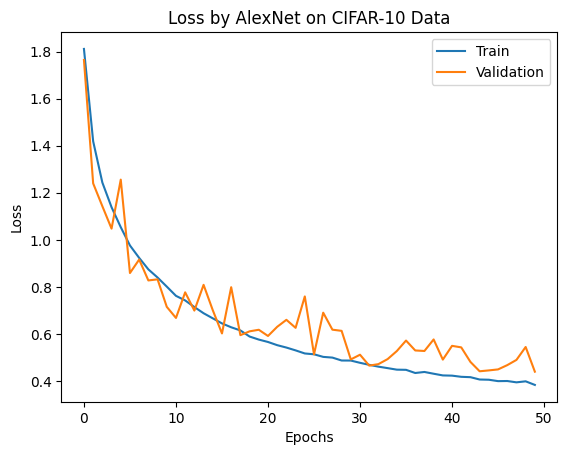

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy by AlexNet on CIFAR-10 Data")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss by AlexNet on CIFAR-10 Data')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

In [16]:
y_predictions1 = AlexNet.predict(x_test)
y_predictions1.reshape(-1,)
y_predictions1= np.argmax(y_predictions1, axis=1)

confusion_matrix(y_test, y_predictions1)

313/313 [==============================] - 1s 3ms/step


array([[871,  16,  20,  11,   3,   5,   6,   9,  23,  36],
       [  3, 958,   1,   1,   0,   3,   0,   0,   3,  31],
       [ 42,   7, 782,  20,  37,  34,  44,  25,   3,   6],
       [ 15,  11,  29, 657,  37, 140,  44,  37,   9,  21],
       [  9,   1,  30,  24, 822,  15,  35,  58,   3,   3],
       [  7,   6,  11,  75,  21, 811,  14,  43,   1,  11],
       [  7,   3,  10,  19,   5,  10, 938,   2,   2,   4],
       [  3,   2,  11,   9,  11,  24,   3, 928,   1,   8],
       [ 50,  31,   6,   6,   1,   1,   2,   4, 871,  28],
       [  3,  52,   2,   4,   0,   0,   0,   4,   5, 930]])

313/313 [==============================] - 1s 3ms/step


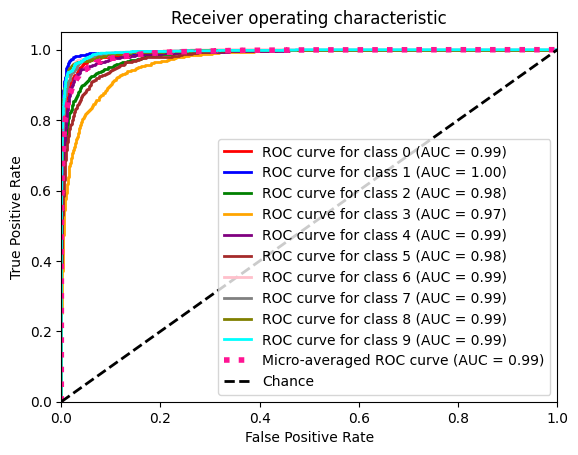

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


# Make predictions on test data
y_score = AlexNet.predict(x_test)

# Convert labels to one-hot encoded form
y_test_one_hot = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Calculate FPR and TPR for each class
fpr = {}
tpr = {}
roc_auc = {}
num_classes = len(classes)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-averaged FPR and TPR
fpr_micro, tpr_micro, _ = roc_curve(y_test_one_hot.ravel(), y_score.ravel())

# Calculate micro-averaged AUC
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve for class %d (AUC = %0.2f)' % (i, roc_auc[i]))

# Plot micro-averaged ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=4, linestyle=':', label='Micro-averaged ROC curve (AUC = %0.2f)' % roc_auc_micro)

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Display plot
plt.show()



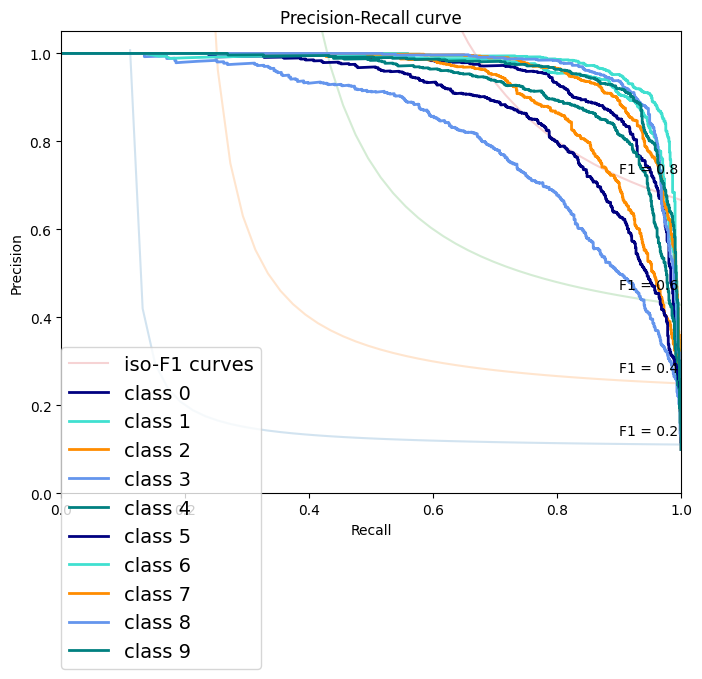

In [29]:
from sklearn.metrics import precision_recall_curve
from itertools import cycle
# Convert the test dataset labels to one-hot encoded format
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the precision, recall, and thresholds using the precision_recall_curve function
precision = dict()
recall = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])

# Plot the Precision-Recall curve
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.figure(figsize=(8, 6))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
lines.append(l)
labels.append('iso-F1 curves')
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('class {0}'.format(i))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
plt.show()

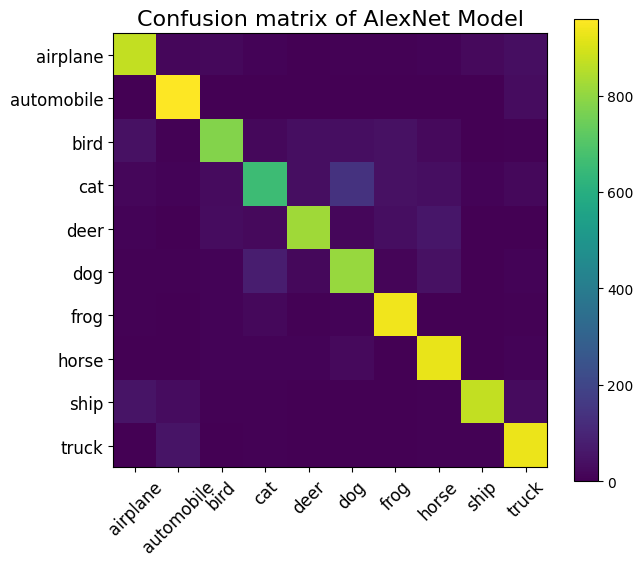

In [17]:
# confusion matrix and accuracy
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix of AlexNet Model', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_predictions1))
plt.xticks(np.arange(10), classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), classes, fontsize=12)
plt.colorbar()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
print("Test accuracy by AlexNet:", accuracy_score(y_test, y_predictions1))

Test accuracy by AlexNet: 0.8568


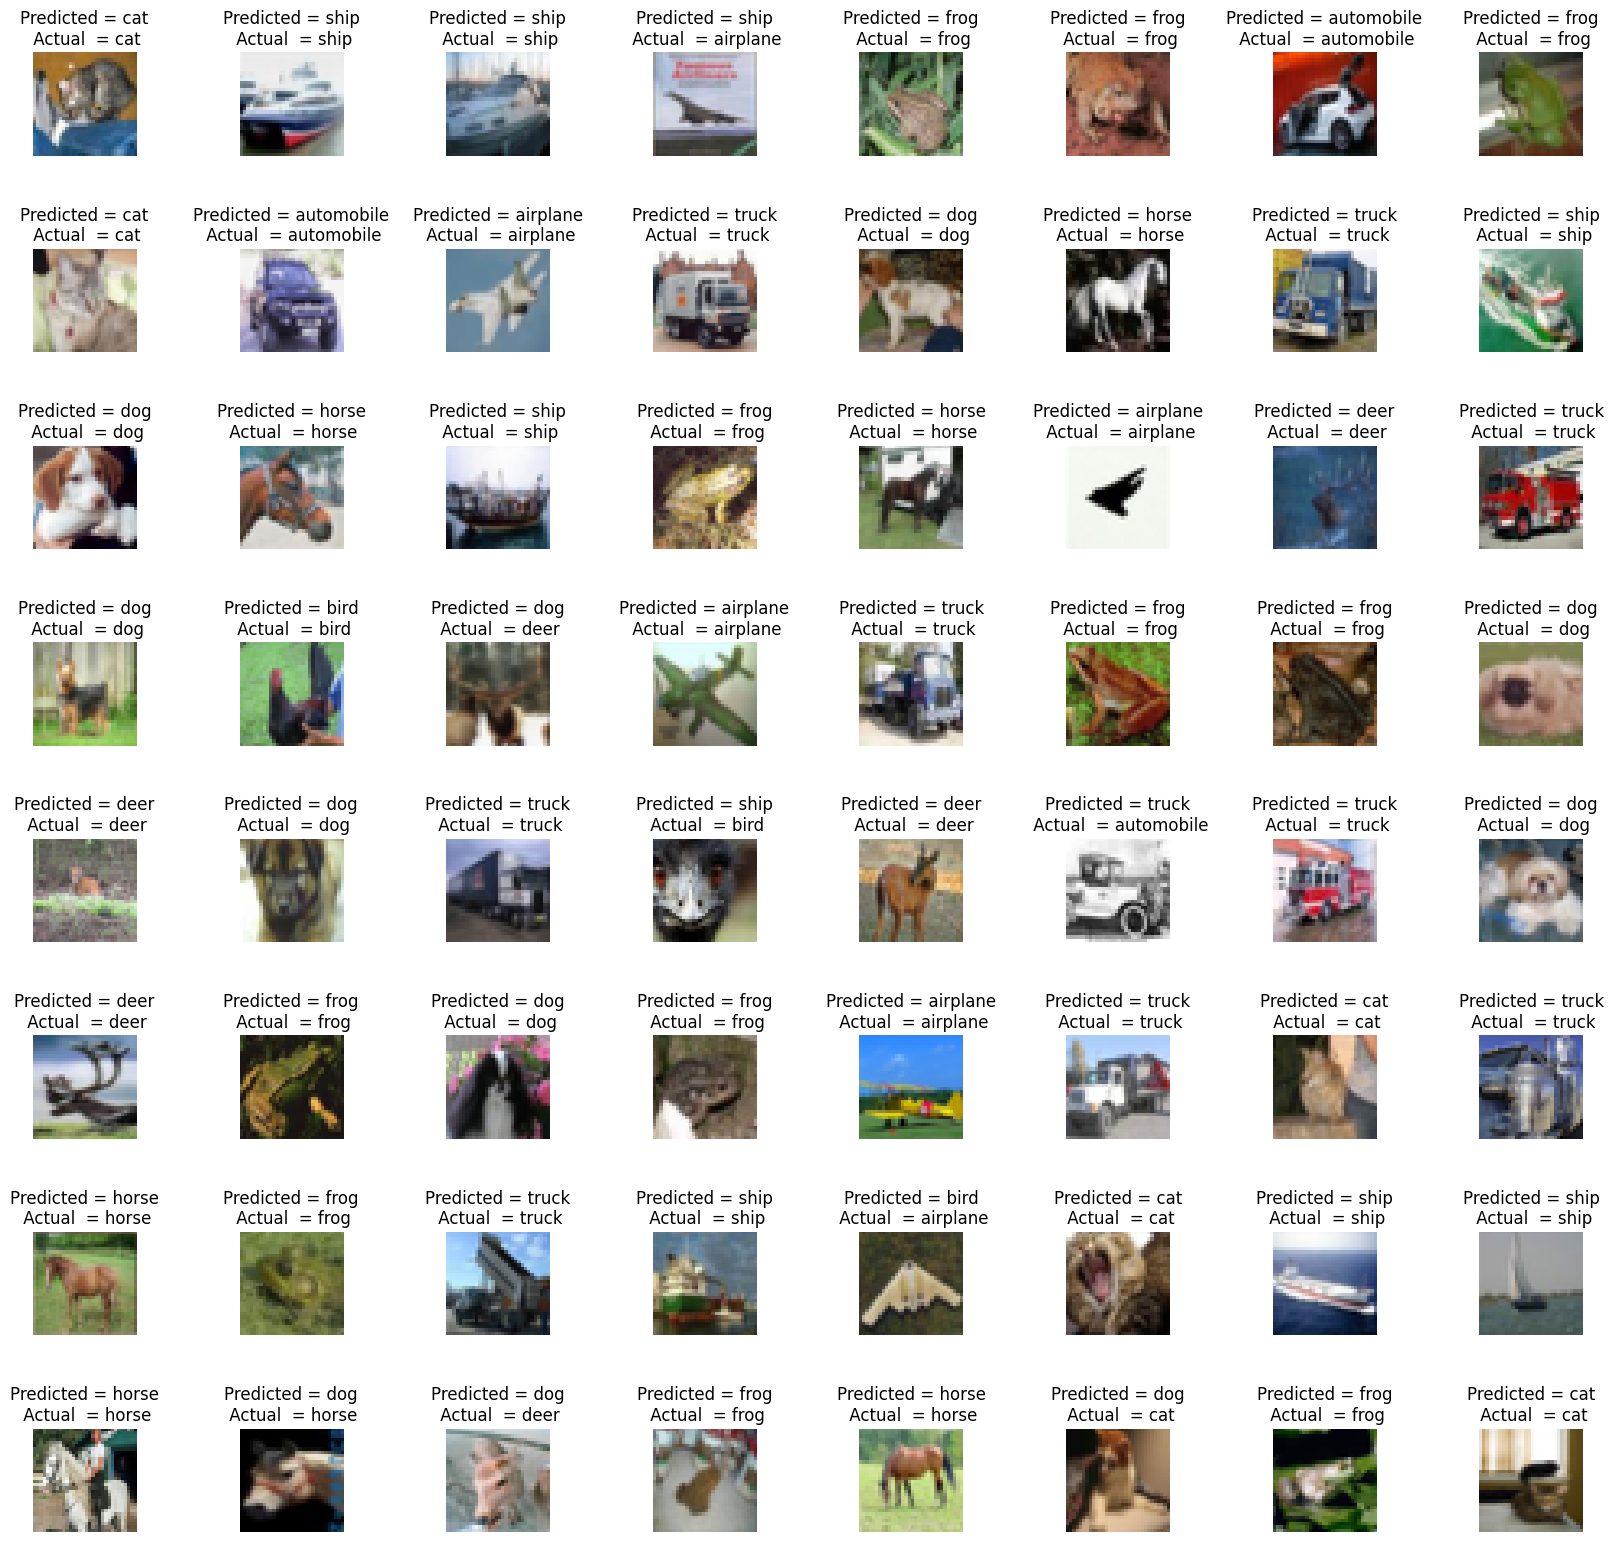

In [19]:
L = 8
W = 8
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(x_test[i])
    axes[i].set_title("Predicted = {}\n Actual  = {}".format(classes[y_predictions1[i]], classes[y_test[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)